# CNN - Slice Predictor

Here we develop a CNN that takes as input 2 axial slices of a brain image and predicts the central axial slice. Note we only use b=0 intensity values

### Upload the data required

We use both scans of subjects 1-8 from the PETMR dataset for training.

We used the scan of subjects 9-10 also from the PETMR dataset for testing.

## FUNCTIONS

In [53]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

In [54]:
def get_data(petmr_path, test_data, training_data, numb_training_scans, numb_testing_scans):
    os.chdir(petmr_path)
    count = 0
    for direc in os.listdir(os.getcwd())[1:]:
        scan_image = nib.load(str(petmr_path) + "/" + str(direc) + "/Brain_Extracted.nii.gz")
        scan_data = scan_image.get_data()
        #all scans have the same affine map because registration has already been performed
        #we only need it for saving the predictions as a NIfTI file
        affine_mat = scan_image.affine
        #get b=0 volumes only
        bvals_scan, bvecs_scan = read_bvals_bvecs(str(petmr_path) + "/" + str(direc) + "/NODDI.bval",\
                                                  str(petmr_path) + "/" + str(direc) + "/NODDI.bvec")
        gtab_scan = gradient_table(bvals_scan, bvecs_scan)
        s0s_scan = scan_data[:, :, :, gtab_scan.b0s_mask]
        
        if(count < numb_training_scans):
            #append this data to the list containing the training data
            training_data.append(s0s_scan)
        else:
            testing_data.append(s0s_scan)
        count += 1
        if(count == (numb_training_scans + numb_testing_scans)):
            break
    return (training_data, test_data, affine_mat)

In [55]:
#It is necessary to pad the data since each scan can be of a different size
#This helps with the normalisation of the volumes
#Also helps with training and testing because we can use batches (must be same dimensions)

#Note we do not pad the depth dimension as we will be using axial slice volumes
def pad_data(dataset):
    max_width = 0
    max_hight = 0
    
    #iterate through the scans and update the above stats
    for scan in dataset:
        (width, hight, depth, volume) = scan.shape
        if width > max_width:
            max_width = width
        if hight > max_hight:
            max_hight = hight
            
    #iterate throug the scans again and pad them based on the max stats
    for index, scan in enumerate(dataset):
        #get padding dimensions
        (width, hight, depth, volume) = scan.shape
        pad_width = max_width-width
        pad_hight = max_hight-hight
        
        pad_w_b = pad_width/2
        pad_w_a = pad_width-pad_w_b
        
        pad_h_b = pad_hight/2
        pad_h_a = pad_hight-pad_h_b
        
        padding = ((pad_w_b, pad_w_a), (pad_h_b, pad_h_a), (0,0), (0,0))
        aug_scan = np.pad(scan, padding, mode='constant', constant_values=0)
        dataset[index] = aug_scan
    return dataset

In [56]:
#This function appends to a list all sets of 3-adjacent slices from a scan.
#This is done for all volumes of a scan

#Note we can also calculate the mean and std of the data at this stage in prep for normalisatioin
def slicify(data_scan, slice_store_inputs, slice_store_targets):
    (x,y,z,v) = data_scan.shape
    for volume in range(v):
        for i in range(0,z):
            #check that there exists a slice above
            if(i+2 < z):
                slice_store_inputs.append(np.stack((data_scan[:, :, i, volume], data_scan[:, :, i+2, volume]), axis=2))
                slice_store_targets.append(data_scan[:, :, i+1, volume])
            else:
                break
    return (slice_store_inputs ,slice_store_targets)


In [57]:
def normalise(dataset, mean=None, std=None):
    data_array = np.array(dataset)
    if mean==None and std==None:
        #This is the training data
        mean = np.mean(data_array)
        std = np.std(data_array)
    #normalise the data
    data_array = (data_array - mean)/std
    return (data_array, mean, std)

In [58]:
def viz_data(input_data, target_data, volume):
    plt.figure
    plt.figure(figsize=(6,6))
    plt.subplot(1, 3, 1).set_axis_off()
    plt.imshow(input_data[volume][:, :, 0].T, cmap='gray', origin='lower')
    plt.title("Lower")
    plt.subplot(1, 3, 2).set_axis_off()
    plt.imshow(target_data[volume][:,:].T, cmap='gray', origin='lower')
    plt.title("Target")
    plt.subplot(1, 3, 3).set_axis_off()
    plt.imshow(input_data[volume][:, :, 1].T, cmap='gray', origin='lower')
    plt.title("Upper")
    plt.show()

In [59]:
def viz_pred(inputs, predictions, labels, volume):
    plt.figure
    plt.figure(figsize=(10,10))
    plt.subplot(3, 3, 2).set_axis_off()
    plt.imshow(inputs[:,:,1,0,volume].T, cmap='gray', origin='lower')
    plt.title("Above")
    plt.subplot(3, 3, 4).set_axis_off()
    plt.imshow(np.mean(inputs[:,:,:,0,volume], axis=2).T, cmap='gray', origin='lower')
    plt.title("Average")
    plt.subplot(3, 3, 5).set_axis_off()
    plt.imshow(predictions[:,:,0,0,volume].T, cmap='gray', origin='lower')
    plt.title("Predicted")
    plt.subplot(3, 3, 6).set_axis_off()
    plt.imshow(labels[:,:,0,0,volume].T, cmap='gray', origin='lower')
    plt.title("Actual")
    plt.subplot(3, 3, 8).set_axis_off()
    plt.imshow(inputs[:,:,0,0,volume].T, cmap='gray', origin='lower')
    plt.title("Below")
    plt.show()

In [60]:
def viz_diff(predictions, inputs, labels, volume):
    difference = predictions[:,:,0,0,volume] - labels[:,:,0,0,volume]
    difference_inputs = ((np.mean(inputs[:,:,:,0,volume], axis=2) * std) + mean) - labels[:,:,0,0,volume]
    plt.figure
    plt.figure(figsize=(6,6))
    plt.subplot(1, 2, 1).set_axis_off()
    plt.imshow(np.absolute(difference).T, cmap='nipy_spectral', origin='lower', clim=[1,1000])
    plt.colorbar(shrink=0.5)
    plt.title("Differnce Predicted")
    plt.subplot(1, 2, 2).set_axis_off()
    plt.imshow(np.absolute(difference_inputs).T, cmap='nipy_spectral', origin='lower', clim=[1,1000])
    plt.colorbar(shrink=0.5)
    plt.title("Differnce Mean")

-------------------------------------------------------------------------------------------------------
---

-------------------------------------------------------------------------------------------------------
---



#### Upload the data

In [61]:
#upload the data
petmr_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data'
training_data = []
testing_data = []
(training_data, testing_data, affine_mat) = get_data(petmr_data_path, testing_data, training_data, 18, 1)
print ("Number of scans used for training: %d" % len(training_data))
print ("Number of scans used for testing: %d" % len(testing_data))

Number of scans used for training: 18
Number of scans used for testing: 1


#### Pad the data

In [62]:
training_data = pad_data(training_data)
testing_data = pad_data(testing_data)

#### Slice up the data (Axial slices)

In [63]:
training_slices_input = []
training_slices_target = []
testing_slices_input = []
testing_slices_target = []
for scan in training_data:
    (training_slices_input, training_slices_target) = slicify(scan, training_slices_input, training_slices_target)
for scan in testing_data:
    (testing_slices_input, testing_slices_target) = slicify(scan, testing_slices_input, testing_slices_target)

In [64]:
print ("Nember of training examples : %d" % len(training_slices_input))
print ("Nember of testing examples : %d" % len(testing_slices_input))

Nember of training examples : 11102
Nember of testing examples : 624


In [65]:
testing_data[0].shape

(53, 63, 50, 13)

#### Visualise the data

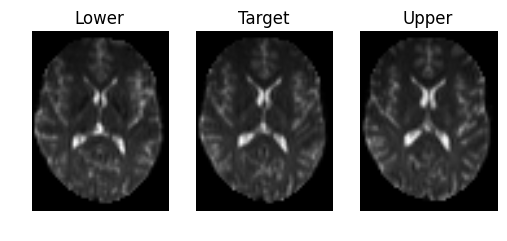

In [66]:
viz_data(training_slices_input, training_slices_target, 23)

#### Normalise the training data inputs

In [67]:
#These are now numpy arrays
training_slices_input, mean, std = normalise(training_slices_input)
testing_slices_input, _, _ = normalise(testing_slices_input, mean, std)

training_slices_target = np.array(training_slices_target)
testing_slices_target = np.array(testing_slices_target)

## PYTORCH FUNCTIONS

In [68]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [69]:
#create a dataset class for our data

class MRIdataset(Dataset):
    """MRI b=0 dataset for axial slice volumes."""

    def __init__(self, input_slices, target_slices, transform=None):
        """
        Args:
            input_slices: Input slices
            target_slices: Corresponding target slice of the input slices
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.input_slices = input_slices
        self.target_slices = target_slices
        self.transform = transform

    def __len__(self):
        return self.input_slices.shape[0]

    def __getitem__(self, idx):
        input_slice = self.input_slices[idx]
        #Exapnd dims of target to make it have a depth of 1
        target_slice = np.expand_dims(self.target_slices[idx], 2)
        sample = {'input': input_slice, 'target': target_slice}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [70]:
class To_Tensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        inp, out = sample['input'], sample['target']
        
        #first expand dimension because torch expects H x W x D x C
        #currently we only have H x W x D
        aug_inp = np.expand_dims(inp, 3)
        aug_out = np.expand_dims(out, 3)

        # swap channel axis because
        # numpy: H x W x D x C
        # torch: C x D x H x W
        aug_inp = aug_inp.transpose((3, 2, 0, 1))
        aug_out = aug_out.transpose((3, 2, 0, 1))
        return {'input': torch.Tensor(aug_inp),
                'target': torch.Tensor(aug_out)}


In [71]:
def train(net, training_dataset, trainloader, losses_list, optimizer, criterion, epochs):
    net.train()
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0): #done in batches
            # get the inputs
            inputs = data['input']
            labels = data['target']

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize/update weights
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0] #loss is a variable tensor of size 1, we index to get the value out
            if i % 250 == 249:    # print every 250 mini-batches
                print('[%d, %5d]' % (epoch + 1, i + 1))
        total_loss = running_loss / len(training_dataset)
        losses_list.append(total_loss)
        print('Loss iteration %d = %.5f' % (epoch+1, total_loss ))
        '''   
        test_error = 0
        total = 0
        for test_data in testloader: #batch processing
            test_inputs = test_data['inp']
            test_labels = test_data['out']
            total += len(test_labels)

            test_outputs = net(Variable(test_inputs))

            test_error += (torch.nn.functional.mse_loss(test_outputs.data, test_labels, size_average=False)).data[0]

        test_error /= total
        print('MSE on test data: %f' % (test_error))
        Adam_acc.append(test_error)
        '''
    print('Finished Training')
    return (net, losses_list)

In [72]:
def plt_losses(losses_list):
    plt.figure
    plt.plot(range(1,len(losses_list)+1), losses_list, 'r-')
    plt.xlabel('iteration')
    # Make the y-axis label, ticks and tick labels match the line color.
    plt.ylabel('Loss')
    plt.show()

In [73]:
 def testing_error(net, testloader):
    net.eval()
    test_error = 0
    total = 0
    for test_data in testloader: #batch processing
        test_inputs = test_data['input']
        test_labels = test_data['target']
        total += len(test_labels)

        test_outputs = net(Variable(test_inputs))
        
        #Use MSE loss
        test_error += (torch.nn.functional.mse_loss(test_outputs.data, test_labels, size_average=False)).data[0]

    test_error /= total
    return test_error

In [74]:
 def mean_prediction_error(testloader):
    test_error_average_prediction = 0
    total = 0
    for test_data in testloader: #batch processing
        test_inputs_avg = test_data['input']
        test_labels_avg = test_data['target']
        total += len(test_labels_avg)

        test_outputs_avg = torch.mean(test_inputs_avg, 2, keepdim=True)
        test_outputs_avg = (test_outputs_avg * float(std)) + float(mean)

        #Use MSE loss
        test_error_average_prediction += (torch.nn.functional.mse_loss(test_outputs_avg, test_labels_avg, size_average=False)).data[0]
    test_error_average_prediction /= total
    return test_error_average_prediction

In [75]:
def get_predictions(net, testloader):
    net.eval()
    for index, test_data in enumerate(testloader): #batch processing
            test_inputs = test_data['input']
            test_labels = test_data['target']

            test_outputs = net(Variable(test_inputs))

            if(index == 0):
                predictions = test_outputs.data.numpy() 
                labels = test_labels.numpy()
                inputs = test_inputs.numpy()

            else:
                predictions = np.concatenate((predictions, test_outputs.data.numpy()), axis=0)
                labels = np.concatenate((labels, test_labels.numpy()), axis=0)
                inputs = np.concatenate((inputs, test_inputs.numpy()), axis=0)

    #convert back to numpy dimensions of (HxWxDxCxNumbExpls)
    predictions = predictions.transpose(3,4,2,1,0)
    labels = labels.transpose(3,4,2,1,0)
    inputs = inputs.transpose(3,4,2,1,0)
    
    return(predictions, labels, inputs)

-------------------------------------------------------------------------------------------------------
---

-------------------------------------------------------------------------------------------------------
---



### Upload the data using pytorch data loaders

In [76]:
training_dataset = MRIdataset(training_slices_input, training_slices_target, transform=transforms.Compose([To_Tensor()]))
testing_dataset = MRIdataset(testing_slices_input, testing_slices_target, transform=transforms.Compose([To_Tensor()]))

In [77]:
#Note: we keep a batch size of 1 due to inconsistent tensor sizes
trainloader = DataLoader(training_dataset, batch_size=2,
                        shuffle=True, num_workers=8)
testloader = DataLoader(testing_dataset, batch_size=1,
                        shuffle=False, num_workers=8)

### Develop CNN

Conv -> Batch -> Relu -> Conv -> Batch -> Relu -> Conv -> Batch -> Relu -> Conv -> Relu

--(WxHx2x1)--

conv1 = receptive field -> (3x3x3), zero padding -> 2,  number of filters -> 10

--(W+2xH+2x4x10)--

--BATCH then RELU--

conv2 = receptive field -> (1x1x1), number of filters -> 15

--(W+2xH+2x4x15)--

--BATCH then RELU--

conv3 = receptive field -> (3x3x3), number of filters -> 15

--(WxHx2x15)--

--BATCH then RELU--

conv4 = receptive field -> (1x1x2), number of filters -> 1

--(WxHx1x1)--

--RELU--




In [146]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1, 10, 3, padding=2)
        self.batch1 = nn.BatchNorm3d(10)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv3d(10, 15, 1)
        self.batch2 = nn.BatchNorm3d(15)
        self.drop2 = nn.Dropout(p=0.4)
        self.conv3 = nn.Conv3d(15, 15, 3)
        self.batch3 = nn.BatchNorm3d(15)
        self.drop3 = nn.Dropout(p=0.3)
        self.conv4 = nn.Conv3d(15, 1, (2,1,1), (2,1,1))

    #note this method isn't called explicitly during train, 
    #rather the instance object is called as pytorch is then 
    #able to take care of other stuff in the background
    def forward(self, x):
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.relu(self.conv4(x))
        return x


net = Net()
print(net)

Net (
  (conv1): Conv3d(1, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2))
  (batch1): BatchNorm3d(10, eps=1e-05, momentum=0.1, affine=True)
  (drop1): Dropout (p = 0.2)
  (conv2): Conv3d(10, 15, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (batch2): BatchNorm3d(15, eps=1e-05, momentum=0.1, affine=True)
  (drop2): Dropout (p = 0.4)
  (conv3): Conv3d(15, 15, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (batch3): BatchNorm3d(15, eps=1e-05, momentum=0.1, affine=True)
  (drop3): Dropout (p = 0.3)
  (conv4): Conv3d(15, 1, kernel_size=(2, 1, 1), stride=(2, 1, 1))
)


### Define loss function and optimization algorithm

In [142]:
#here we use MSE loss
criterion = nn.MSELoss(size_average=False) #returns the sum over a mini-batch as opposed to the average
optimizer = optim.Adam(net.parameters(), lr=0.1)

### Train CNN

In [145]:
(trained_net, adam_losses) = train(net, training_dataset, trainloader, [], optimizer, criterion, 4)

[1,   250]
[1,   500]
[1,   750]
[1,  1000]


Process Process-151:
Process Process-146:
Process Process-149:
Process Process-152:
Process Process-147:
Process Process-145:
Process Process-150:
Process Process-148:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/System/Library/

KeyboardInterrupt: 

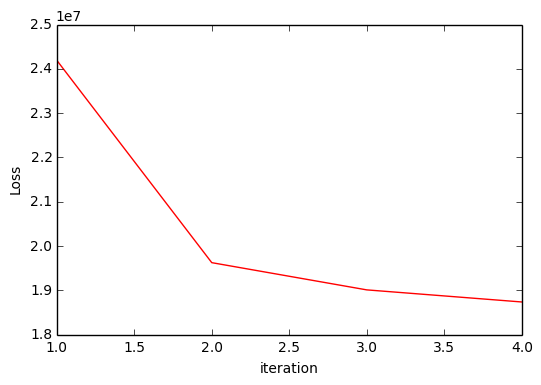

In [82]:
plt_losses(adam_losses)

### Calculate MSE on testing data

In [83]:
test_error = testing_error(trained_net, testloader)
print('MSE on test data: %f\n' % (test_error))

print ("Mean intensity per voxel : %f" % mean)
print ("Mean error per voxel : %f" % \
       (np.sqrt(test_error)/(training_dataset[0]['target'].shape[2] * training_dataset[0]['target'].shape[3])))

MSE on test data: 27108465.101763

Mean intensity per voxel : 169.100311
Mean error per voxel : 1.403391


### Calculate MSE of predictions found by averaging the 2 input slices

In [84]:
test_error_average_prediction = mean_prediction_error(testloader)
print('MSE of CNN prediction on test data: %f' % (test_error))
print('MSE of mean prediction on test data: %f' % (test_error_average_prediction))

print ("MSE of mean predictions is %f times larger than that of the CNN predictions"\
       % (test_error_average_prediction/test_error))


MSE of CNN prediction on test data: 27108465.101763
MSE of mean prediction on test data: 46861272.107772
MSE of mean predictions is 1.728658 times larger than that of the CNN predictions


### Store predictions in a numpy array

In [123]:
(predictions, labels, inputs) = get_predictions(trained_net, testloader)

In [119]:
predictions.shape

(53, 63, 1, 1, 624)

In [125]:
#make intensity values start form 0
predictions = predictions - predictions.min()

In [129]:
predictions[predictions<170] = 170

### Visualise predictions

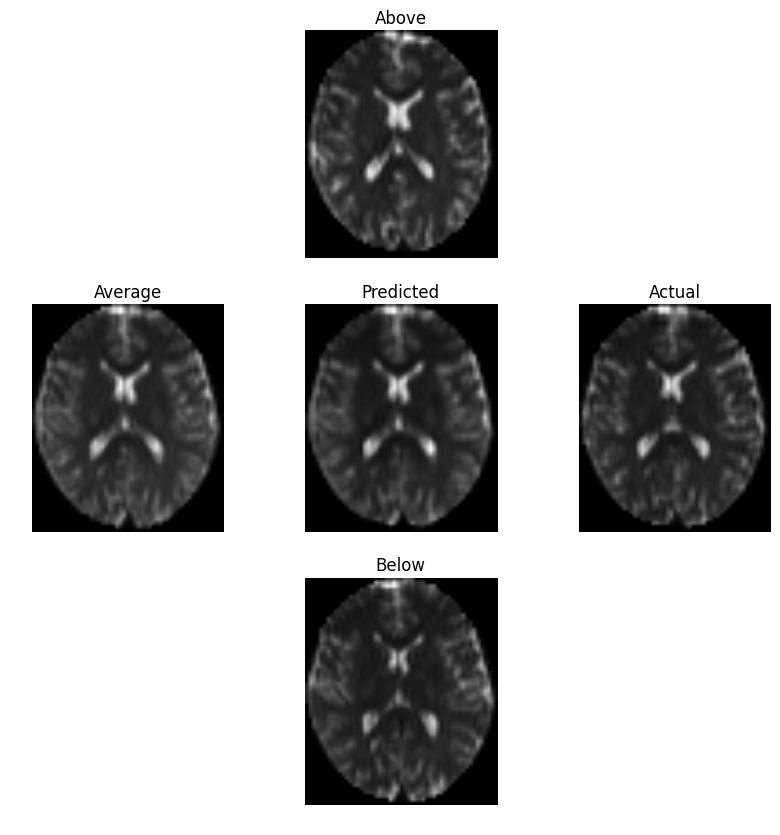

In [140]:
viz_pred(inputs, predictions, labels, 25)

### Visualise error

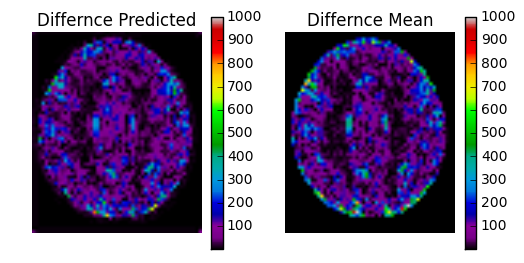

In [88]:
viz_diff(predictions, inputs, labels, 80)

### Convert predictions to NIfTI dataset

In [89]:
#we must reshape this exact way - daw
reshaped_predictions = np.reshape(predictions, (53,63,13,48));
#ctranspose to get matrix of dimensions (HxWxDxC)
reshaped_predictions = reshaped_predictions.transpose(0,1,3,2)


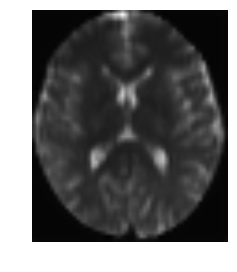

In [90]:
plt.figure(figsize=(3,3));
plt.imshow(reshaped_predictions[:, :, 24, 7].T, cmap='gray', origin='lower');
plt.axis('off');

In [94]:
print reshaped_predictions.max()
print reshaped_predictions.min()

print testing_data[0].max()
print testing_data[0].min()

2943.03
-94.6796
3499.0
0.0


In [97]:
reshaped_predictions

array([[[[ 40.10805511,  40.10805511,  40.10805511, ...,  40.10805511,
           40.10805511,  40.10805511],
         [ 40.10805511,  40.10805511,  40.10805511, ...,  40.10805511,
           40.10805511,  40.10805511],
         [ 40.10805511,  40.10805511,  40.10805511, ...,  40.10805511,
           40.10805511,  40.10805511],
         ..., 
         [ 40.10805511,  40.10805511,  40.10805511, ...,  40.10805511,
           40.10805511,  40.10805511],
         [ 40.10805511,  40.10805511,  40.10805511, ...,  40.10805511,
           40.10805511,  40.10805511],
         [ 40.10805511,  40.10805511,  40.10805511, ...,  40.10805511,
           40.10805511,  40.10805511]],

        [[  3.98473549,   3.98473549,   3.98473549, ...,   3.98473549,
            3.98473549,   3.98473549],
         [  3.98473549,   3.98473549,   3.98473549, ...,   3.98473549,
            3.98473549,   3.98473549],
         [  3.98473549,   3.98473549,   3.98473549, ...,   3.98473549,
            3.98473549,   3.9847

In [91]:
print ("Saving the prdeicted image")
petmr_scan_img_predicted = nib.Nifti1Image(reshaped_predictions.astype(np.float32), affine_mat)
nib.save(petmr_scan_img_predicted, "/Volumes/Seagate Backup Plus Drive/Project/Dataset/Sliced_B0_V1/Normal/Brain_Predicted_Slices_B0.nii.gz")

print ("Saving the actual image")
petmr_scan_img_actual = nib.Nifti1Image(testing_data[0][:,:,1:49,:].astype(np.float32), affine_mat)
nib.save(petmr_scan_img_actual, "/Volumes/Seagate Backup Plus Drive/Project/Dataset/Sliced_B0_V1/Normal/Brain_Actual_Slices_B0.nii.gz")

Saving the prdeicted image


IOError: [Errno 2] No such file or directory: '/Volumes/Seagate Backup Plus Drive/Project/Dataset/Sliced_B0_V1/normal/Brain_Predicted_Slices_B0.nii.gz'

### Save the trained model parameters

In [47]:
torch.save(trained_net.state_dict(), '/Volumes/Seagate Backup Plus Drive/Project/Dataset/Sliced_B0_V1/normal/model.pth') 

### Load the trained model

In [51]:
loaded_net = Net()
loaded_net.load_state_dict(torch.load('/Volumes/Seagate Backup Plus Drive/Project/Dataset/Sliced_B0_V1/Normal/model.pth'))

In [52]:
#Check if loading worked
test_error = testing_error(loaded_net, testloader)
print('MSE on test data: %f\n' % (test_error))

print ("Mean intensity per voxel : %f" % mean)
print ("Mean error per voxel : %f" % \
       (np.sqrt(test_error)/(training_dataset[0]['target'].shape[2] * training_dataset[0]['target'].shape[3])))

MSE on test data: 28288902.659054

Mean intensity per voxel : 169.100311
Mean error per voxel : 1.433620
